<h1 style="text-align: center;"> Image Classification using Transfer Learning & CNN </h1>
<h1 style="text-align: center;"> Computer Vision Laboratory Assignment 7 </h1>
<h2 style="text-align: center;"> 122CS0067 Amiya Chowdhury 06/03/2025 </h2>

<h3>1. Two Class Classification of Skin_Cancer Dataset </h3>


A. Use a pretrained VGG-16 model on Imagenet dataset by removing the top fully connected layers and adding three dense layers having 64, 32 and 2 neurons with relu, sigmoid and softmax activation functions respectively for classifying the two class Skin_Cancer RGB dataset given in Teams.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import os
import glob as gb
import cv2
import PIL
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , Dense , Dropout , Flatten , MaxPooling2D , BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow import keras
from keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pwd

'C:\\Users\\Admin\\Desktop\\122CS0067\\Lab-7'

In [22]:
#data path
trainpath = 'C:\\Users\\Admin\\Desktop\\122CS0067\\Lab-7\\Skin_Cancer\\train' #Please give the path where you are saving the train folder.
testpath = 'C:\\Users\\Admin\\Desktop\\122CS0067\\Lab-7\\Skin_Cancer\\test' #please give the path where you are saving the test folder.

In [42]:
# Train Images
new_size=224
train_images=[]
train_labels=[]
all_descriptors = []
sift = cv2.SIFT_create()
for i in os.listdir(trainpath):
  print("Entering to the folder name:",i)
  files=gb.glob(pathname=str(trainpath+'/' + i + '/*.jpg'))
  print("Number of images in the folder is",len(files))
  for j in files:
      class_cancer={'benign':0,'malignant':1}
      image_raw=cv2.imread(j)
      image=cv2.cvtColor(image_raw,cv2.COLOR_BGR2RGB)
      resize_image=cv2.resize(image,(new_size,new_size))
      train_images.append(list(resize_image))
      train_labels.append(class_cancer[i])
      keypoints, descriptors = sift.detectAndCompute(image, None)
        
      if descriptors is not None:
        all_descriptors.append(descriptors)

        
sift_descriptors_train = np.vstack(all_descriptors) 

Entering to the folder name: benign
Number of images in the folder is 25
Entering to the folder name: malignant
Number of images in the folder is 25


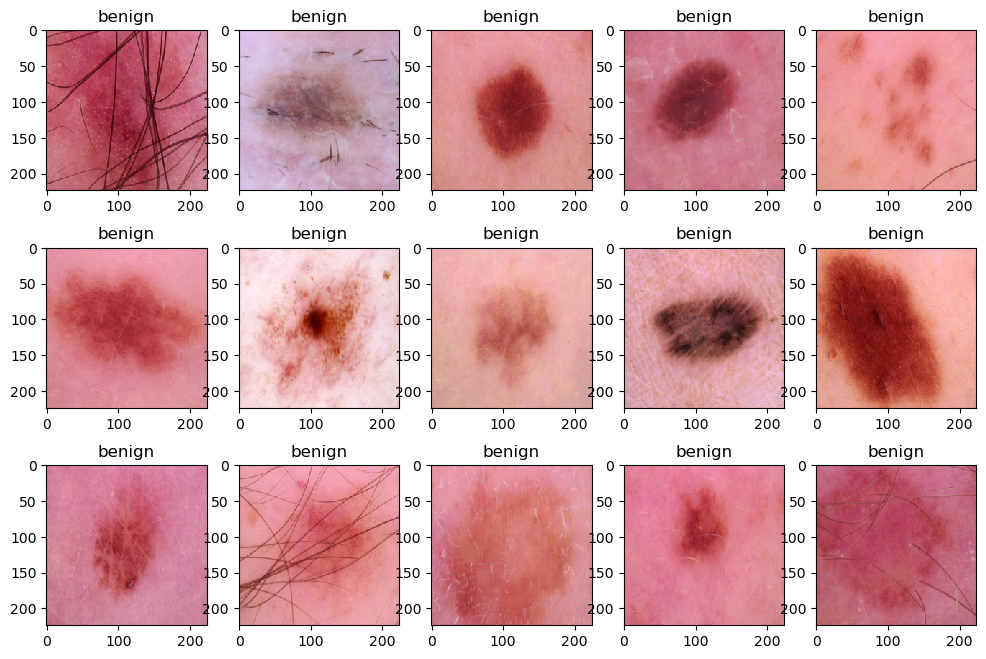

In [67]:
# Visualizing Train Images
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if train_labels[i] == 0:
        ax.title.set_text('benign')
    elif train_labels[i] == 1:
        ax.title.set_text('malignant')
    plt.imshow(train_images[i], interpolation='nearest')
plt.show()

In [43]:
# Test Images
new_size=224
test_images=[]
test_labels=[]
all_descriptors = []
sift = cv2.SIFT_create()
for i in os.listdir(testpath):# entering to the test folder
  print("Entering to the folder name:",i)
  files=gb.glob(pathname=str(testpath +'/' + i + '/*.jpg'))# pointing to all the .jpg extension image folder
  print("Number of images in the folder is",len(files))
  class_cancer={'benign':0,'malignant':1}
  for j in files:
      image_raw=cv2.imread(j)
      image=cv2.cvtColor(image_raw,cv2.COLOR_BGR2RGB)
      resize_image=cv2.resize(image,(new_size,new_size))
      test_images.append(list(resize_image))
      test_labels.append(class_cancer[i])
      keypoints, descriptors = sift.detectAndCompute(image, None)
        
      if descriptors is not None:
        all_descriptors.append(descriptors)

        
sift_descriptors_test = np.vstack(all_descriptors) 

Entering to the folder name: benign
Number of images in the folder is 25
Entering to the folder name: malignant
Number of images in the folder is 25


In [8]:
def list_to_array_train(train_images,train_labels):
  return np.array(train_images),np.array(train_labels)

X_train,y_train=list_to_array_train(train_images,train_labels)


def list_to_array_test(test_images,test_labels):
  return np.array(test_images),np.array(test_labels)


X_test,y_test=list_to_array_test(test_images,test_labels)

In [7]:
print(X_train.shape)
print("*"*20)
print(y_train.shape)
print("*"*20)
print(X_test.shape)
print(y_test.shape)

(50, 224, 224, 3)
********************
(50,)
********************
(50, 224, 224, 3)
(50,)


In [9]:
def keras_to_categorical(y_train,y_test):
  return to_categorical(y_train),to_categorical(y_test)

y_train,y_test=keras_to_categorical(y_train,y_test)
y_train.shape,y_test.shape

((90, 3), (75, 3))

In [9]:
def model_vgg16():
  VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
  #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
  for layer in VGG_model.layers:
    layer.trainable = False #True for actual transfer learning
  feature=keras.layers.GlobalAveragePooling2D()(VGG_model.output)
  d1=Dense(units=64,kernel_initializer="glorot_uniform", activation='relu')(feature)
  d2=Dense(units=32,kernel_initializer="glorot_uniform", activation='sigmoid')(d1)
  d3=Dense(units=2,kernel_initializer="glorot_uniform", activation='softmax')(d2)
  output = Model(inputs =VGG_model.input, outputs =d3)
  
  return output

model16=model_vgg16()

In [10]:
model16.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'],run_eagerly=True)
history = model16.fit(X_train, y_train, validation_split=0.2,epochs= 10, batch_size= 1, verbose=1,validation_data=(X_test,y_test))


Epoch 1/10

50/50 [==============================] - 69s 1s/step - loss: 0.6143 - accuracy: 0.7200 - val_loss: 0.5055 - val_accuracy: 0.8000
Epoch 2/10
50/50 [==============================] - 66s 1s/step - loss: 0.3859 - accuracy: 0.8600 - val_loss: 0.4831 - val_accuracy: 0.8000
Epoch 3/10
50/50 [==============================] - 67s 1s/step - loss: 0.2931 - accuracy: 0.9400 - val_loss: 0.4075 - val_accuracy: 0.8200
Epoch 4/10
50/50 [==============================] - 69s 1s/step - loss: 0.1830 - accuracy: 0.9200 - val_loss: 0.3296 - val_accuracy: 0.8400
Epoch 5/10
50/50 [==============================] - 67s 1s/step - loss: 0.1201 - accuracy: 0.9800 - val_loss: 0.2871 - val_accuracy: 0.8800
Epoch 6/10
50/50 [==============================] - 68s 1s/step - loss: 0.0668 - accuracy: 1.0000 - val_loss: 0.3984 - val_accuracy: 0.8200
Epoch 7/10
50/50 [==============================] - 67s 1s/step - loss: 0.0407 - accuracy: 1.0000 - val_loss: 0.4493 - val_accuracy: 0.8200
Epoch 8/10
50/50 [

B. Use a pretrained VGG-16 model on Imagenet dataset by removing the top fully connected layers and extracting the deep features and modelling them using a Random Forest classifier for classifying the two class Skin_Cancer RGB dataset given in Teams.

In [11]:
def f_model_vgg16():
  VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
  #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
  for layer in VGG_model.layers:
    layer.trainable = False #True for actual transfer learning
  feature=keras.layers.GlobalAveragePooling2D()(VGG_model.output)
  output = Model(inputs =VGG_model.input, outputs =feature)
  
  return output

model_FE_16=f_model_vgg16()

In [12]:
model_FE_16.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy',run_eagerly=True)
train_feature_16=model_FE_16.predict(X_train)
test_feature_16=model_FE_16.predict(X_test)

2/2 [==============================] - 12s 4s/step


Train Accuracy Score 1.0
Test Accuracy Score 0.8


<AxesSubplot:title={'center':'Confusion Matrix'}>

<Figure size 640x480 with 0 Axes>

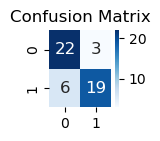

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf=rf.fit(train_feature_16,y_train)
train_pred=rf.predict(train_feature_16)
test_pred=rf.predict(test_feature_16)
print("Train Accuracy Score",accuracy_score(train_pred,y_train))
print("Test Accuracy Score",accuracy_score(test_pred,y_test))
fig = plt.figure(1)
plt.figure(figsize=(1,1))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test.argmax(axis=1),test_pred.argmax(axis=1))
sns.heatmap(cm,cmap="Blues",cbar=True, annot=True,annot_kws={"size": 12})

C.	Use pretrained VGG-16 and VGG-19 model on Imagenet dataset by removing the top fully connected layers and extract the deep features, fuse the deep features and model them using a Random Forest classifier for classifying the two class Skin_Cancer RGB dataset given in Teams.

In [14]:
def f_model_vgg19():
  VGG_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224, 3))
  #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
  for layer in VGG_model.layers:
    layer.trainable = False #True for actual transfer learning
  feature=keras.layers.GlobalAveragePooling2D()(VGG_model.output)
  output = Model(inputs =VGG_model.input, outputs =feature)
  
  return output

model_FE_19=f_model_vgg19()

In [15]:
model_FE_19.compile(optimizer='Adam', loss='mse', metrics='accuracy',run_eagerly=True)
train_feature_19=model_FE_19.predict(X_train)
test_feature_19=model_FE_19.predict(X_test)

2/2 [==============================] - 14s 5s/step


In [16]:
final_train=np.hstack((train_feature_16,train_feature_19))
final_test=np.hstack((test_feature_16,test_feature_19))

Train Accuracy Score 1.0
Test Accuracy Score 0.78


<AxesSubplot:title={'center':'Confusion Matrix'}>

<Figure size 640x480 with 0 Axes>

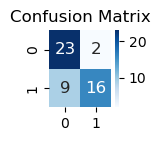

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf=rf.fit(final_train,y_train)
train_pred=rf.predict(final_train)
test_pred=rf.predict(final_test)
print("Train Accuracy Score",accuracy_score(train_pred,y_train))
print("Test Accuracy Score",accuracy_score(test_pred,y_test))
fig = plt.figure(1)
plt.figure(figsize=(1,1))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test.argmax(axis=1),test_pred.argmax(axis=1))
sns.heatmap(cm,cmap="Blues",cbar=True, annot=True,annot_kws={"size": 12})

<h3>2. Three Class Classification of Orange_Dataset </h3>

A. Use a pretrained VGG-16 model on Imagenet dataset by removing the top fully connected layers and adding three dense layers having 64, 32 and 3 neurons with relu, sigmoid and softmax activation functions respectively for classifying the three class Orange_Dataset RGB dataset given in Teams. 

In [4]:
#data path
trainpath = 'C:\\Users\\Admin\\Desktop\\122CS0067\\Lab-7\\Orange_Dataset\\train' #Please give the path where you are saving the train folder.
testpath = 'C:\\Users\\Admin\\Desktop\\122CS0067\\Lab-7\\Orange_Dataset\\test' #please give the path where you are saving the test folder.

In [5]:
new_size=224
train_images=[]
train_labels=[]
for i in os.listdir(trainpath):#entering train folder
  print("Entering to the folder name:",i)
  files=gb.glob(pathname=str(trainpath+'/' + i + '/*.jpg'))# pointing to all the .jpg extension image folder
  print("Number of images in the folder is",len(files))
  for j in files:# reading each images
      class_citrus={'Healthy':0,'BlackSpot':1,'Anthracnose':2}
      image_raw=cv2.imread(j)
      image=cv2.cvtColor(image_raw,cv2.COLOR_BGR2RGB)
      resize_image=cv2.resize(image,(new_size,new_size))
      train_images.append(list(resize_image))
      train_labels.append(class_citrus[i])

Entering to the folder name: Anthracnose
Number of images in the folder is 30
Entering to the folder name: BlackSpot
Number of images in the folder is 30
Entering to the folder name: Healthy
Number of images in the folder is 30


In [6]:
new_size=224
test_images=[]
test_labels=[]
for i in os.listdir(testpath):# entering to the test folder
  print("Entering to the folder name:",i)
  files=gb.glob(pathname=str(testpath +'/' + i + '/*.jpg'))# pointing to all the .jpg extension image folder
  print("Number of images in the folder is",len(files))
  for j in files:
      class_citrus={'Healthy':0,'BlackSpot':1,'Anthracnose':2}
      image_raw=cv2.imread(j)
      image=cv2.cvtColor(image_raw,cv2.COLOR_BGR2RGB)
      resize_image=cv2.resize(image,(new_size,new_size))
      test_images.append(list(resize_image))
      test_labels.append(class_citrus[i])

Entering to the folder name: Anthracnose
Number of images in the folder is 25
Entering to the folder name: BlackSpot
Number of images in the folder is 25
Entering to the folder name: Healthy
Number of images in the folder is 25


In [25]:
X_train,y_train=list_to_array_train(train_images,train_labels)
X_test,y_test=list_to_array_test(test_images,test_labels)

In [26]:
print(X_train.shape)
print("*"*20)
print(y_train.shape)
print("*"*20)
print(X_test.shape)
print(y_test.shape)

(50, 224, 224, 3)
********************
(50,)
********************
(50, 224, 224, 3)
(50,)


In [27]:
y_train,y_test=keras_to_categorical(y_train,y_test)
y_train.shape,y_test.shape

((50, 2), (50, 2))

In [81]:
def model_vgg16_2():
  VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
  #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
  for layer in VGG_model.layers:
    layer.trainable = False #True for actual transfer learning
  feature=keras.layers.GlobalAveragePooling2D()(VGG_model.output)
  d1=Dense(units=64,kernel_initializer="glorot_uniform", activation='relu')(feature)
  d2=Dense(units=32,kernel_initializer="glorot_uniform", activation='sigmoid')(d1)
  d3=Dense(units=3,kernel_initializer="glorot_uniform", activation='softmax')(feature)
  output = Model(inputs =VGG_model.input, outputs =d3)
  
  return output



In [82]:
model_16_or=model_vgg16_2()
model_16_or.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'],run_eagerly=True)


In [83]:
history = model_16_or.fit(X_train, y_train, validation_split=0.2,epochs= 10, batch_size= 1, verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
90/90 [==============================] - 116s 1s/step - loss: 0.9155 - accuracy: 0.7333 - val_loss: 0.9063 - val_accuracy: 0.7467
Epoch 2/10
90/90 [==============================] - 125s 1s/step - loss: 0.0219 - accuracy: 0.9889 - val_loss: 0.3551 - val_accuracy: 0.8933
Epoch 3/10
90/90 [==============================] - 121s 1s/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.2957 - val_accuracy: 0.9200
Epoch 4/10
90/90 [==============================] - 127s 1s/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.2553 - val_accuracy: 0.9200
Epoch 5/10
90/90 [==============================] - 118s 1s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2539 - val_accuracy: 0.9200
Epoch 6/10
90/90 [==============================] - 118s 1s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2322 - val_accuracy: 0.9200
Epoch 7/10
90/90 [==============================] - 118s 1s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2139 - val_accuracy: 0.9200
Epoch 8/10
90

B.	Use a pretrained VGG-16 model on Imagenet dataset by removing the top fully connected layers and extracting the deep features and modelling them using a Random Forest classifier for classifying the three class Orange_Dataset RGB dataset given in Teams.

In [84]:
#using model of 1.b to extract deep feature(VGG16)
train_feature_16=model_FE_16.predict(X_train)
test_feature_16=model_FE_16.predict(X_test)

3/3 [==============================] - 17s 5s/step


Train Accuracy Score 1.0
Test Accuracy Score 1.0


<AxesSubplot:title={'center':'Confusion Matrix'}>

<Figure size 640x480 with 0 Axes>

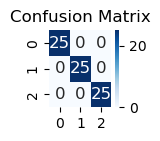

In [85]:
rf=RandomForestClassifier()
rf=rf.fit(train_feature_16,y_train)
train_pred=rf.predict(train_feature_16)
test_pred=rf.predict(test_feature_16)
print("Train Accuracy Score",accuracy_score(train_pred,y_train))
print("Test Accuracy Score",accuracy_score(test_pred,y_test))
fig = plt.figure(1)
plt.figure(figsize=(1,1))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test.argmax(axis=1),test_pred.argmax(axis=1))
sns.heatmap(cm,cmap="Blues",cbar=True, annot=True,annot_kws={"size": 12})

C.	Use pretrained VGG-16 and VGG-19 model on Imagenet dataset by removing the top fully connected layers and extract the deep features, fuse the deep features and model them using a Random Forest classifier for classifying the three class Orange_Dataset RGB dataset given in Teams.

In [86]:
#using model of 1.c to extract deep feature(VGG16)
train_feature_19=model_FE_19.predict(X_train)
test_feature_19=model_FE_19.predict(X_test)
#fusing features
final_train=np.hstack((train_feature_16,train_feature_19))
final_test=np.hstack((test_feature_16,test_feature_19))

3/3 [==============================] - 22s 6s/step


Train Accuracy Score 1.0
Test Accuracy Score 1.0


<AxesSubplot:title={'center':'Confusion Matrix'}>

<Figure size 640x480 with 0 Axes>

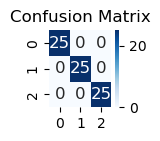

In [87]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf=rf.fit(final_train,y_train)
train_pred=rf.predict(final_train)
test_pred=rf.predict(final_test)
print("Train Accuracy Score",accuracy_score(train_pred,y_train))
print("Test Accuracy Score",accuracy_score(test_pred,y_test))
fig = plt.figure(1)
plt.figure(figsize=(1,1))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test.argmax(axis=1),test_pred.argmax(axis=1))
sns.heatmap(cm,cmap="Blues",cbar=True, annot=True,annot_kws={"size": 12})

In [15]:
from keras.applications.inception_v3 import InceptionV3
#IncpetionV1->GoogLENET

In [16]:
model=InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3))



87910968/87910968 [==============================] - 27s 0us/step


In [18]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

 conv2d_11 (Conv2D)          (None, 25, 25, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 25, 25, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 25, 25, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 25, 25, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 25, 25, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 25, 25, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 25, 25, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 25, 25, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 12, 12, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 12, 12, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 12, 12, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 12, 12, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 12, 12, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 12, 12, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 5, 5, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 5, 5, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 5, 5, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 5, 5, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 5, 5, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [20]:
for layer in model.layers:
    layer.trainable=False
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

 conv2d_11 (Conv2D)          (None, 25, 25, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 25, 25, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 25, 25, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 25, 25, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 25, 25, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 25, 25, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 25, 25, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 25, 25, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 12, 12, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 12, 12, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 12, 12, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 12, 12, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 12, 12, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 12, 12, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 5, 5, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 5, 5, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 5, 5, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 5, 5, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 5, 5, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [23]:
x = model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=model.input, outputs=predictions)

In [25]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'],run_eagerly=True)

In [27]:
history = model.fit(X_train, y_train, validation_split=0.2,epochs= 10, verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
3/3 [==============================] - 39s 16s/step - loss: 0.5764 - accuracy: 0.9667 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
3/3 [==============================] - 39s 16s/step - loss: 1.7297e-06 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 3/10
3/3 [==============================] - 39s 16s/step - loss: 0.7160 - accuracy: 0.9222 - val_loss: 4.9977 - val_accuracy: 0.6267
Epoch 4/10
3/3 [==============================] - 40s 17s/step - loss: 2.0860 - accuracy: 0.8667 - val_loss: 3.0969 - val_accuracy: 0.7333
Epoch 5/10
3/3 [==============================] - 39s 16s/step - loss: 0.9965 - accuracy: 0.9444 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 39s 16s/step - loss: 0.0284 - accuracy: 0.9889 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 39s 16s/step - loss: 7.5499e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8


<h2 style="text-align: center;">122CS0067 13/03/2025 Transfer Learning (VGG-16 and ResNet)</h2>

In [13]:
def f_model_vgg16():
  VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
  #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
  for layer in VGG_model.layers:
    layer.trainable = False #True for actual transfer learning
  feature=keras.layers.GlobalAveragePooling2D()(VGG_model.output)
  output = Model(inputs =VGG_model.input, outputs =feature)
  
  return output

model_FE_16=f_model_vgg16()

In [16]:
from keras.applications.resnet import ResNet50

In [17]:
def f_model_resnet50():
  ResNet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224, 3))
  #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
  for layer in ResNet_model.layers:
    layer.trainable = False #True for actual transfer learning
  feature=keras.layers.GlobalAveragePooling2D()(ResNet_model.output)
  output = Model(inputs =ResNet_model.input, outputs =feature)
  
  return output

model_FE_RN=f_model_resnet50()

94765736/94765736 [==============================] - 338s 4us/step


In [28]:
model_FE_16.compile(optimizer='Adam', loss='mse', metrics='accuracy',run_eagerly=True)
train_feature_16=model_FE_16.predict(X_train)
test_feature_16=model_FE_16.predict(X_test)

2/2 [==============================] - 12s 4s/step


In [29]:
model_FE_RN.compile(optimizer='Adam', loss='mse', metrics='accuracy',run_eagerly=True)
train_feature_RN=model_FE_RN.predict(X_train)
test_feature_RN=model_FE_RN.predict(X_test)

2/2 [==============================] - 6s 2s/step


In [30]:
#fusing features
final_train=np.hstack((train_feature_16,train_feature_RN))
final_test=np.hstack((test_feature_16,test_feature_RN))

Train Accuracy Score 1.0
Test Accuracy Score 0.92


<AxesSubplot:title={'center':'Confusion Matrix'}>

<Figure size 640x480 with 0 Axes>

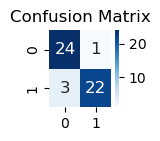

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf=rf.fit(final_train,y_train)
train_pred=rf.predict(final_train)
test_pred=rf.predict(final_test)
print("Train Accuracy Score",accuracy_score(train_pred,y_train))
print("Test Accuracy Score",accuracy_score(test_pred,y_test))
fig = plt.figure(1)
plt.figure(figsize=(1,1))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test.argmax(axis=1),test_pred.argmax(axis=1))
sns.heatmap(cm,cmap="Blues",cbar=True, annot=True,annot_kws={"size": 12})

In [32]:
from sklearn.decomposition import PCA

Train Accuracy Score 1.0
Test Accuracy Score 0.4


<AxesSubplot:title={'center':'Confusion Matrix'}>

<Figure size 640x480 with 0 Axes>

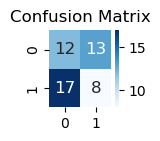

In [33]:
principal12=PCA(n_components=12)
final_train_reduced12 = PCA(n_components=12).fit_transform(final_train)
final_test_reduced12 = PCA(n_components=12).fit_transform(final_test)
rf=RandomForestClassifier()
rf=rf.fit(final_train_reduced12,y_train)
train_pred=rf.predict(final_train_reduced12)
test_pred=rf.predict(final_test_reduced12)
print("Train Accuracy Score",accuracy_score(train_pred,y_train))
print("Test Accuracy Score",accuracy_score(test_pred,y_test))
fig = plt.figure(1)
plt.figure(figsize=(1,1))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test.argmax(axis=1),test_pred.argmax(axis=1))
sns.heatmap(cm,cmap="Blues",cbar=True, annot=True,annot_kws={"size": 12})

Train Accuracy Score 1.0
Test Accuracy Score 0.34


<AxesSubplot:title={'center':'Confusion Matrix'}>

<Figure size 640x480 with 0 Axes>

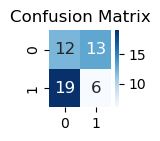

In [35]:
final_train_reduced24 = PCA(n_components=24).fit_transform(final_train)
final_test_reduced24 = PCA(n_components=24).fit_transform(final_test)
rf1=RandomForestClassifier()
rf1=rf1.fit(final_train_reduced24,y_train)
train_pred=rf1.predict(final_train_reduced24)
test_pred=rf1.predict(final_test_reduced24)
print("Train Accuracy Score",accuracy_score(train_pred,y_train))
print("Test Accuracy Score",accuracy_score(test_pred,y_test))
fig = plt.figure(1)
plt.figure(figsize=(1,1))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test.argmax(axis=1),test_pred.argmax(axis=1))
sns.heatmap(cm,cmap="Blues",cbar=True, annot=True,annot_kws={"size": 12})

Train Accuracy Score 1.0
Test Accuracy Score 0.42


<AxesSubplot:title={'center':'Confusion Matrix'}>

<Figure size 640x480 with 0 Axes>

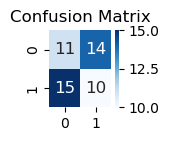

In [36]:
final_train_reduced36 = PCA(n_components=36).fit_transform(final_train)
final_test_reduced36 = PCA(n_components=36).fit_transform(final_test)
rf2=RandomForestClassifier()
rf2=rf2.fit(final_train_reduced36,y_train)
train_pred=rf2.predict(final_train_reduced36)
test_pred=rf2.predict(final_test_reduced36)
print("Train Accuracy Score",accuracy_score(train_pred,y_train))
print("Test Accuracy Score",accuracy_score(test_pred,y_test))
fig = plt.figure(1)
plt.figure(figsize=(1,1))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test.argmax(axis=1),test_pred.argmax(axis=1))
sns.heatmap(cm,cmap="Blues",cbar=True, annot=True,annot_kws={"size": 12})

In [37]:
from sklearn.decomposition import FastICA

Train Accuracy Score 1.0
Test Accuracy Score 0.5


<AxesSubplot:title={'center':'Confusion Matrix'}>

<Figure size 640x480 with 0 Axes>

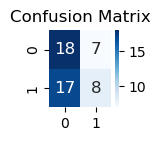

In [38]:
final_train_ica12 = FastICA(n_components=12).fit_transform(final_train)
final_test_ica12 = FastICA(n_components=12).fit_transform(final_test)
rf=RandomForestClassifier()
rf=rf.fit(final_train_ica12,y_train)
train_pred=rf.predict(final_train_ica12)
test_pred=rf.predict(final_test_ica12)
print("Train Accuracy Score",accuracy_score(train_pred,y_train))
print("Test Accuracy Score",accuracy_score(test_pred,y_test))
fig = plt.figure(1)
plt.figure(figsize=(1,1))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test.argmax(axis=1),test_pred.argmax(axis=1))
sns.heatmap(cm,cmap="Blues",cbar=True, annot=True,annot_kws={"size": 12})

Train Accuracy Score 1.0
Test Accuracy Score 0.6


<AxesSubplot:title={'center':'Confusion Matrix'}>

<Figure size 640x480 with 0 Axes>

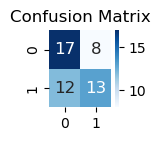

In [39]:
final_train_ica24 = FastICA(n_components=24).fit_transform(final_train)
final_test_ica24 = FastICA(n_components=24).fit_transform(final_test)
rf=RandomForestClassifier()
rf=rf.fit(final_train_ica24,y_train)
train_pred=rf.predict(final_train_ica24)
test_pred=rf.predict(final_test_ica24)
print("Train Accuracy Score",accuracy_score(train_pred,y_train))
print("Test Accuracy Score",accuracy_score(test_pred,y_test))
fig = plt.figure(1)
plt.figure(figsize=(1,1))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test.argmax(axis=1),test_pred.argmax(axis=1))
sns.heatmap(cm,cmap="Blues",cbar=True, annot=True,annot_kws={"size": 12})

Train Accuracy Score 1.0
Test Accuracy Score 0.58


<AxesSubplot:title={'center':'Confusion Matrix'}>

<Figure size 640x480 with 0 Axes>

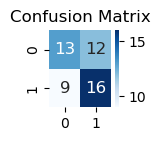

In [40]:
final_train_ica36 = FastICA(n_components=36).fit_transform(final_train)
final_test_ica36 = FastICA(n_components=36).fit_transform(final_test)
rf=RandomForestClassifier()
rf=rf.fit(final_train_ica36,y_train)
train_pred=rf.predict(final_train_ica36)
test_pred=rf.predict(final_test_ica36)
print("Train Accuracy Score",accuracy_score(train_pred,y_train))
print("Test Accuracy Score",accuracy_score(test_pred,y_test))
fig = plt.figure(1)
plt.figure(figsize=(1,1))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test.argmax(axis=1),test_pred.argmax(axis=1))
sns.heatmap(cm,cmap="Blues",cbar=True, annot=True,annot_kws={"size": 12})

Train Accuracy Score 1.0
Test Accuracy Score 0.96


<AxesSubplot:title={'center':'Confusion Matrix'}>

<Figure size 640x480 with 0 Axes>

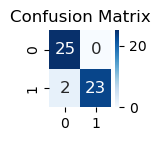

In [61]:
final_train=np.hstack((sift_features_train,train_feature_RN))
final_test=np.hstack((sift_features_test,test_feature_RN))
rf=RandomForestClassifier()
rf=rf.fit(final_train,y_train)
train_pred=rf.predict(final_train)
test_pred=rf.predict(final_test)
print("Train Accuracy Score",accuracy_score(train_pred,y_train))
print("Test Accuracy Score",accuracy_score(test_pred,y_test))
fig = plt.figure(1)
plt.figure(figsize=(1,1))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test.argmax(axis=1),test_pred.argmax(axis=1))
sns.heatmap(cm,cmap="Blues",cbar=True, annot=True,annot_kws={"size": 12})

In [56]:
sift_features_train = []  

sift = cv2.SIFT_create()

for i in os.listdir(trainpath): 
    print("Entering to the folder name:", i)
    files = gb.glob(pathname=str(trainpath + '/' + i + '/*.jpg'))
    print("Number of images in the folder is", len(files))
    
    for j in files:  
        class_cancer={'benign':0,'malignant':1}
        image_raw = cv2.imread(j)
        image = cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB)
        resize_image = cv2.resize(image, (new_size, new_size))
        
    
        gray_image = cv2.cvtColor(resize_image, cv2.COLOR_RGB2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray_image, None)
        
        if descriptors is None or len(descriptors) == 0:
        
            sift_features_train.append(np.zeros(128, dtype=np.float32))
        else:
            mean_descriptor = np.mean(descriptors, axis=0)
            sift_features_train.append(mean_descriptor)

sift_features_train = np.array(sift_features_train)
print("Shape of sift_features:", sift_features_train.shape)

Entering to the folder name: benign
Number of images in the folder is 25
Entering to the folder name: malignant
Number of images in the folder is 25
Shape of sift_features: (50, 128)


In [57]:
sift_features_test = []  

sift = cv2.SIFT_create()

for i in os.listdir(testpath):
    print("Entering to the folder name:", i)
    files = gb.glob(pathname=str(trainpath + '/' + i + '/*.jpg'))
    print("Number of images in the folder is", len(files))
    
    for j in files:
        class_cancer={'benign':0,'malignant':1}
        image_raw = cv2.imread(j)
        image = cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB)
        resize_image = cv2.resize(image, (new_size, new_size))
        gray_image = cv2.cvtColor(resize_image, cv2.COLOR_RGB2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray_image, None)
        
        if descriptors is None or len(descriptors) == 0:
            sift_features_test.append(np.zeros(128, dtype=np.float32))
        else:
            mean_descriptor = np.mean(descriptors, axis=0)
            sift_features_test.append(mean_descriptor)

sift_features_test = np.array(sift_features_test)
print("Shape of sift_features:", sift_features_test.shape)

Entering to the folder name: benign
Number of images in the folder is 25
Entering to the folder name: malignant
Number of images in the folder is 25
Shape of sift_features: (50, 128)


In [67]:
new_size = 128 

hog = cv2.HOGDescriptor(
    _winSize=(new_size, new_size),
    _blockSize=(16, 16),
    _blockStride=(8, 8),  
    _cellSize=(8, 8),  
    _nbins=9 
)

hog_features_test = []  

for i in os.listdir(testpath):
    print("Entering to the folder name:", i)
    files = gb.glob(pathname=str(testpath + '/' + i + '/*.jpg'))
    print("Number of images in the folder is", len(files))
    
    for j in files:
        class_cancer = {'benign': 0, 'malignant': 1}
        image_raw = cv2.imread(j)
        image = cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB)
        resize_image = cv2.resize(image, (new_size, new_size))
        gray_image = cv2.cvtColor(resize_image, cv2.COLOR_RGB2GRAY)
        hog_features = hog.compute(gray_image)
        hog_features_test.append(hog_features.flatten())  

hog_features_test = np.array(hog_features_test)
print("Shape of hog_features:", hog_features_test.shape)

Entering to the folder name: benign
Number of images in the folder is 25
Entering to the folder name: malignant
Number of images in the folder is 25
Shape of hog_features: (50, 8100)


In [66]:
new_size = 128 

hog = cv2.HOGDescriptor(
    _winSize=(new_size, new_size), 
    _blockSize=(16, 16), 
    _blockStride=(8, 8),  
    _cellSize=(8, 8),  
    _nbins=9 
)

hog_features_train = []  

for i in os.listdir(trainpath): 
    print("Entering to the folder name:", i)
    files = gb.glob(pathname=str(trainpath + '/' + i + '/*.jpg')) 
    print("Number of images in the folder is", len(files))
    
    for j in files: 
        class_cancer = {'benign': 0, 'malignant': 1}
        image_raw = cv2.imread(j)
        image = cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB)
        resize_image = cv2.resize(image, (new_size, new_size))
        gray_image = cv2.cvtColor(resize_image, cv2.COLOR_RGB2GRAY)
        hog_features = hog.compute(gray_image)
        hog_features_train.append(hog_features.flatten()) 
hog_features_train = np.array(hog_features_train)
print("Shape of hog_features:", hog_features_train.shape)

Entering to the folder name: benign
Number of images in the folder is 25
Entering to the folder name: malignant
Number of images in the folder is 25
Shape of hog_features: (50, 8100)


Train Accuracy Score 1.0
Test Accuracy Score 0.8


<AxesSubplot:title={'center':'Confusion Matrix'}>

<Figure size 640x480 with 0 Axes>

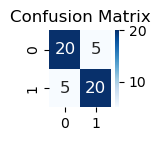

In [74]:
final_train=np.hstack((hog_features_train,train_feature_RN))
final_test=np.hstack((hog_features_test,test_feature_RN))

final_train_reduced24 = PCA(n_components=12).fit_transform(final_train)
final_test_reduced24 = PCA(n_components=12).fit_transform(final_test)
rf1=RandomForestClassifier()
rf1=rf1.fit(final_train_reduced24,y_train)
train_pred=rf1.predict(final_train_reduced24)
test_pred=rf1.predict(final_test_reduced24)
print("Train Accuracy Score",accuracy_score(train_pred,y_train))
print("Test Accuracy Score",accuracy_score(test_pred,y_test))
fig = plt.figure(1)
plt.figure(figsize=(1,1))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test.argmax(axis=1),test_pred.argmax(axis=1))
sns.heatmap(cm,cmap="Blues",cbar=True, annot=True,annot_kws={"size": 12})